Import of libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.1.2/spark-3.1.2-bin-hadoop3.2.tgz
!tar -xvf spark-3.1.2-bin-hadoop3.2.tgz
!pip install -q findspark
!pip install Basemap

os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.2-bin-hadoop3.2"

import findspark
findspark.init()
from pyspark.sql import SparkSession
from pyspark.sql.types import FloatType
from pyspark.sql.functions import udf
from pyspark.sql.functions import regexp_replace, col
from pyspark.sql.types import StringType
from mpl_toolkits.basemap import Basemap
from itertools import chain

In [ ]:
# spark
spark = SparkSession.builder.master("local[*]").getOrCreate()
sc = spark.sparkContext
spark

Helpful functions

In [274]:
def to_float (s) :
   return float(s.replace(',','.'))
   
float_udf = udf(to_float , FloatType())

def draw_map(m, scale=0.2):
    # draw a shaded-relief image
    m.shadedrelief(scale=scale)
    
    # lats and longs are returned as a dictionary
    lats = m.drawparallels(np.linspace(-90, 90, 13))
    lons = m.drawmeridians(np.linspace(-180, 180, 13))

    # keys contain the plt.Line2D instances
    lat_lines = chain(*(tup[1][0] for tup in lats.items()))
    lon_lines = chain(*(tup[1][0] for tup in lons.items()))
    all_lines = chain(lat_lines, lon_lines)
    
    # cycle through these lines and set the desired style
    for line in all_lines:
        line.set(linestyle='-', alpha=0.3, color='w')

def normalize_countries(country):

  result = str(country)
  return result[:-1]

Zad 1

In [6]:
DF_countries = spark.read.csv('countries of the world.csv', header=True,inferSchema=True)

In [7]:
DF = DF_countries.select("Country", "Infant mortality (per 1000 births)", "Literacy (%)", "GDP ($ per capita)").na.drop()

In [8]:
DF.show()

+------------------+----------------------------------+------------+------------------+
|           Country|Infant mortality (per 1000 births)|Literacy (%)|GDP ($ per capita)|
+------------------+----------------------------------+------------+------------------+
|      Afghanistan |                            163,07|        36,0|               700|
|          Albania |                             21,52|        86,5|              4500|
|          Algeria |                                31|        70,0|              6000|
|   American Samoa |                              9,27|        97,0|              8000|
|          Andorra |                              4,05|       100,0|             19000|
|           Angola |                            191,19|        42,0|              1900|
|         Anguilla |                             21,03|        95,0|              8600|
|Antigua & Barbuda |                             19,46|        89,0|             11000|
|        Argentina |            

In [10]:
DF_richest = DF.orderBy(DF["GDP ($ per capita)"].desc())
DF_poor = DF.orderBy(DF["GDP ($ per capita)"].asc())

In [13]:
DF_richest = DF_richest.select("Country", "Infant mortality (per 1000 births)", "Literacy (%)")
DF_poor = DF_poor.select("Country", "Infant mortality (per 1000 births)", "Literacy (%)")

In [14]:
DF_30_richest = DF_richest.limit(30)
DF_30_poor = DF_poor.limit(30)
DF_30_poor.show()

+--------------------+----------------------------------+------------+
|             Country|Infant mortality (per 1000 births)|Literacy (%)|
+--------------------+----------------------------------+------------+
|            Somalia |                             116,7|        37,8|
|       Sierra Leone |                            143,64|        31,4|
|         East Timor |                             47,41|        58,6|
|            Burundi |                             69,29|        51,6|
|           Tanzania |                             98,54|        78,2|
|             Malawi |                            103,32|        62,7|
|           Ethiopia |                             95,32|        42,7|
|        Afghanistan |                            163,07|        36,0|
|            Eritrea |                             74,87|        58,6|
|Congo, Repub. of ...|                             93,86|        83,8|
|   Congo, Dem. Rep. |                             94,69|        65,5|
|     

In [15]:
DF_30_richest.show()

+---------------+----------------------------------+------------+
|        Country|Infant mortality (per 1000 births)|Literacy (%)|
+---------------+----------------------------------+------------+
|    Luxembourg |                              4,81|       100,0|
| United States |                               6,5|        97,0|
|        Norway |                               3,7|       100,0|
|       Bermuda |                              8,53|        98,0|
|Cayman Islands |                              8,19|        98,0|
|    San Marino |                              5,73|        96,0|
|   Switzerland |                              4,39|        99,0|
|       Denmark |                              4,56|       100,0|
|       Iceland |                              3,31|        99,9|
|       Austria |                              4,66|        98,0|
|        Canada |                              4,75|        97,0|
|       Ireland |                              5,39|        98,0|
|       Be

In [16]:
DF_30_richest = DF_30_richest.withColumn("Literacy (%)", float_udf("Literacy (%)"))
DF_30_richest = DF_30_richest.withColumn("Infant mortality (per 1000 births)", float_udf("Infant mortality (per 1000 births)"))
DF_30_poor = DF_30_poor.withColumn("Literacy (%)", float_udf("Literacy (%)"))
DF_30_poor = DF_30_poor.withColumn("Infant mortality (per 1000 births)", float_udf("Infant mortality (per 1000 births)"))

In [17]:
DF_30_poor.show()

+--------------------+----------------------------------+------------+
|             Country|Infant mortality (per 1000 births)|Literacy (%)|
+--------------------+----------------------------------+------------+
|         East Timor |                             47.41|        58.6|
|       Sierra Leone |                            143.64|        31.4|
|            Somalia |                             116.7|        37.8|
|            Burundi |                             69.29|        51.6|
|             Malawi |                            103.32|        62.7|
|           Tanzania |                             98.54|        78.2|
|        Afghanistan |                            163.07|        36.0|
|            Comoros |                             74.93|        56.5|
|   Congo, Dem. Rep. |                             94.69|        65.5|
|Congo, Repub. of ...|                             93.86|        83.8|
|            Eritrea |                             74.87|        58.6|
|     

In [18]:
DF_30_richest_pd = DF_30_richest.toPandas().set_index('Country')
DF_30_poor_pd = DF_30_poor.toPandas().set_index('Country')

In [19]:
DF_30_richest_pd.index

Index(['Luxembourg ', 'Norway ', 'United States ', 'Bermuda ',
       'Cayman Islands ', 'San Marino ', 'Switzerland ', 'Denmark ',
       'Iceland ', 'Austria ', 'Canada ', 'Ireland ', 'Belgium ', 'Australia ',
       'Hong Kong ', 'Netherlands ', 'Japan ', 'Aruba ', 'United Kingdom ',
       'France ', 'Germany ', 'Finland ', 'Monaco ', 'Sweden ', 'Italy ',
       'Liechtenstein ', 'Singapore ', 'Taiwan ', 'United Arab Emirates ',
       'Spain '],
      dtype='object', name='Country')

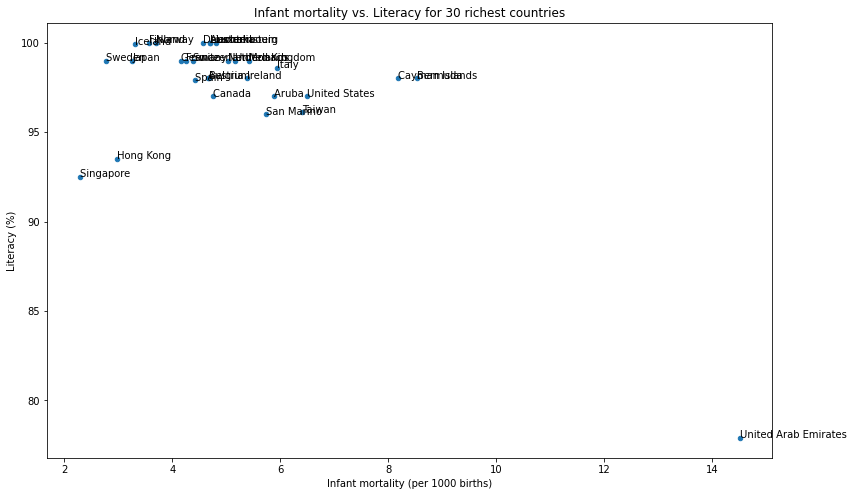

In [277]:
fig = DF_30_richest_pd.plot.scatter(x='Infant mortality (per 1000 births)', y='Literacy (%)', figsize=(13, 8), title='Infant mortality vs. Literacy for 30 richest countries')
for i, txt in enumerate(DF_30_richest_pd.index):
  fig.annotate(txt, (DF_30_richest_pd['Infant mortality (per 1000 births)'][i], DF_30_richest_pd['Literacy (%)'][i]))


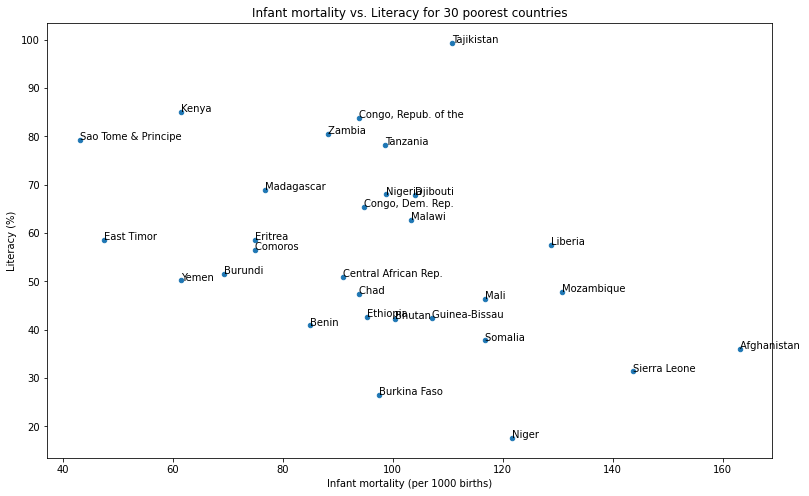

In [278]:
fig = DF_30_poor_pd.plot.scatter(x='Infant mortality (per 1000 births)', y='Literacy (%)', figsize=(13, 8),
                                 title='Infant mortality vs. Literacy for 30 poorest countries')
for i, txt in enumerate(DF_30_poor_pd.index):
  fig.annotate(txt, (DF_30_poor_pd['Infant mortality (per 1000 births)'][i], DF_30_poor_pd['Literacy (%)'][i]))


Zad 2

In [282]:
airports = spark.read.csv('airports.csv',inferSchema=True)

In [283]:
airports = airports.toDF(*("Airport ID",
                                "Name",
                                "City",
                                "Country",
                                "IATA",
                                "ICAO",
                                "Latitude",
                                "Longitude",
                                "Altitude",
                                "Timezone",
                                "DST",
                                "Tz database time",
                                "zone",
                                "Type"))
airports.show()

+----------+--------------------+--------------+----------------+----+----+------------------+-------------------+--------+--------+---+--------------------+-------+-----------+
|Airport ID|                Name|          City|         Country|IATA|ICAO|          Latitude|          Longitude|Altitude|Timezone|DST|    Tz database time|   zone|       Type|
+----------+--------------------+--------------+----------------+----+----+------------------+-------------------+--------+--------+---+--------------------+-------+-----------+
|         1|      Goroka Airport|        Goroka|Papua New Guinea| GKA|AYGA|-6.081689834590001|      145.391998291|    5282|      10|  U|Pacific/Port_Moresby|airport|OurAirports|
|         2|      Madang Airport|        Madang|Papua New Guinea| MAG|AYMD|    -5.20707988739|      145.789001465|      20|      10|  U|Pacific/Port_Moresby|airport|OurAirports|
|         3|Mount Hagen Kagam...|   Mount Hagen|Papua New Guinea| HGU|AYMH|-5.826789855957031| 144.29600524902

In [284]:
coordinates = airports.select("Latitude", 'Longitude').na.drop()
type(coordinates)

pyspark.sql.dataframe.DataFrame

In [285]:
coordinates_pd = coordinates.toPandas()
lats = list(coordinates_pd.iloc[:,0])
longs = list(coordinates_pd.iloc[:,1])

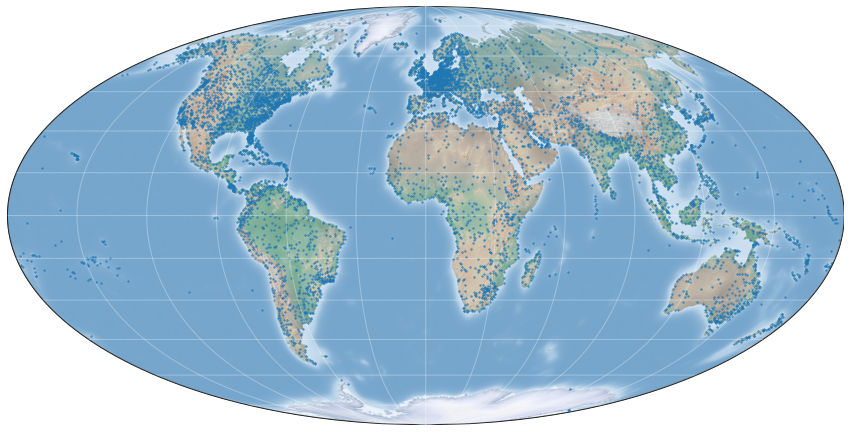

In [286]:
fig = plt.figure(figsize=(15, 10), edgecolor='w')
m = Basemap(projection='moll', resolution=None,
            lat_0=0, lon_0=0)
draw_map(m)
m.scatter(longs, lats, latlon=True,
          cmap='Reds', marker='D', alpha=0.5,  s=2)

Zad 3

In [30]:
airports.show()

+----------+--------------------+--------------+----------------+----+----+------------------+-------------------+--------+--------+---+--------------------+-------+-----------+
|Airport ID|                Name|          City|         Country|IATA|ICAO|          Latitude|          Longitude|Altitude|Timezone|DST|    Tz database time|   zone|       Type|
+----------+--------------------+--------------+----------------+----+----+------------------+-------------------+--------+--------+---+--------------------+-------+-----------+
|         1|      Goroka Airport|        Goroka|Papua New Guinea| GKA|AYGA|-6.081689834590001|      145.391998291|    5282|      10|  U|Pacific/Port_Moresby|airport|OurAirports|
|         2|      Madang Airport|        Madang|Papua New Guinea| MAG|AYMD|    -5.20707988739|      145.789001465|      20|      10|  U|Pacific/Port_Moresby|airport|OurAirports|
|         3|Mount Hagen Kagam...|   Mount Hagen|Papua New Guinea| HGU|AYMH|-5.826789855957031| 144.29600524902

In [287]:
airports = airports.withColumn('distance_SP', (airports.Latitude + 90)**2 + airports.Longitude**2)
ddf = airports.groupby('country').min('distance_SP')
ddf = ddf.withColumnRenamed("country", "kraj")

In [288]:
Nearest_airports = ddf.join(airports, (ddf["min(distance_SP)"] == airports.distance_SP) , 'inner')
Nearest_airports.select('Country', 'Name', 'distance_SP').show()

+-------------+--------------------+------------------+
|      Country|                Name|       distance_SP|
+-------------+--------------------+------------------+
|      Iceland|Vestmannaeyjar Ai...|23950.249973737868|
|       Canada|St. John's Intern...|21721.641697642626|
|        Benin|   Cadjehoun Airport| 9290.400934422278|
| Burkina Faso|Bobo Dioulasso Ai...| 10252.12312811346|
|        Ghana|    Takoradi Airport| 9008.411974697734|
|Cote d'Ivoire|   San Pedro Airport| 9021.307443076701|
|        Niger|Diori Hamani Inte...|10713.188926821065|
|      Tunisia|    El Borma Airport|14897.584604573101|
|         Togo| Lomé-Tokoin Airport| 9249.398310694154|
|      Belgium| Jehonville Air Base|19596.976962157052|
|      Germany|Friedrichshafen A...|19043.855002545395|
|      Finland|   Mariehamn Airport| 22932.61326318895|
|     Guernsey|    Guernsey Airport| 19448.88985562863|
|       Jersey|      Jersey Airport| 19383.65996486516|
|  Isle of Man| Isle of Man Airport|20781.378141

zad 4

In [289]:
airports = airports.withColumnRenamed("Country", "ctry")
airports.show()

+----------+--------------------+--------------+----------------+----+----+------------------+-------------------+--------+--------+---+--------------------+-------+-----------+------------------+
|Airport ID|                Name|          City|            ctry|IATA|ICAO|          Latitude|          Longitude|Altitude|Timezone|DST|    Tz database time|   zone|       Type|       distance_SP|
+----------+--------------------+--------------+----------------+----+----+------------------+-------------------+--------+--------+---+--------------------+-------+-----------+------------------+
|         1|      Goroka Airport|        Goroka|Papua New Guinea| GKA|AYGA|-6.081689834590001|      145.391998291|    5282|      10|  U|Pacific/Port_Moresby|airport|OurAirports|  28181.1159480681|
|         2|      Madang Airport|        Madang|Papua New Guinea| MAG|AYMD|    -5.20707988739|      145.789001465|      20|      10|  U|Pacific/Port_Moresby|airport|OurAirports|28444.272249385238|
|         3|Mou

In [290]:
DF_countries = DF_countries.withColumnRenamed("Area (sq. mi.)", "Area")

In [163]:
normalize_udf = udf(normalize_countries, StringType())
countries_updated = DF_countries.withColumn('Country', normalize_udf('Country'))
countries_updated.show()

+-----------------+--------------------+----------+-------+--------------------------+----------------------------+-------------+----------------------------------+------------------+------------+-----------------+----------+---------+---------+-------+---------+---------+-----------+--------+-------+
|          Country|              Region|Population|   Area|Pop. Density (per sq. mi.)|Coastline (coast/area ratio)|Net migration|Infant mortality (per 1000 births)|GDP ($ per capita)|Literacy (%)|Phones (per 1000)|Arable (%)|Crops (%)|Other (%)|Climate|Birthrate|Deathrate|Agriculture|Industry|Service|
+-----------------+--------------------+----------+-------+--------------------------+----------------------------+-------------+----------------------------------+------------------+------------+-----------------+----------+---------+---------+-------+---------+---------+-----------+--------+-------+
|      Afghanistan|ASIA (EX. NEAR EA...|  31056997| 647500|                      48,0|     

In [204]:
countries_to_merge = countries_updated.select('Country', 'Area', 'Region')
countries_to_merge.show()

+-----------------+-------+--------------------+
|          Country|   Area|              Region|
+-----------------+-------+--------------------+
|      Afghanistan| 647500|ASIA (EX. NEAR EA...|
|          Albania|  28748|EASTERN EUROPE   ...|
|          Algeria|2381740|NORTHERN AFRICA  ...|
|   American Samoa|    199|OCEANIA          ...|
|          Andorra|    468|WESTERN EUROPE   ...|
|           Angola|1246700|SUB-SAHARAN AFRIC...|
|         Anguilla|    102|LATIN AMER. & CAR...|
|Antigua & Barbuda|    443|LATIN AMER. & CAR...|
|        Argentina|2766890|LATIN AMER. & CAR...|
|          Armenia|  29800|C.W. OF IND. STATES |
|            Aruba|    193|LATIN AMER. & CAR...|
|        Australia|7686850|OCEANIA          ...|
|          Austria|  83870|WESTERN EUROPE   ...|
|       Azerbaijan|  86600|C.W. OF IND. STATES |
|     Bahamas, The|  13940|LATIN AMER. & CAR...|
|          Bahrain|    665|NEAR EAST        ...|
|       Bangladesh| 144000|ASIA (EX. NEAR EA...|
|         Barbados| 

In [205]:
airports_to_merge = airports.select('Airport ID', 'ctry')
airports_to_merge.show(20)

+----------+----------------+
|Airport ID|            ctry|
+----------+----------------+
|         1|Papua New Guinea|
|         2|Papua New Guinea|
|         3|Papua New Guinea|
|         4|Papua New Guinea|
|         5|Papua New Guinea|
|         6|Papua New Guinea|
|         7|       Greenland|
|         8|       Greenland|
|         9|       Greenland|
|        10|       Greenland|
|        11|         Iceland|
|        12|         Iceland|
|        13|         Iceland|
|        14|         Iceland|
|        15|         Iceland|
|        16|         Iceland|
|        17|         Iceland|
|        18|         Iceland|
|        19|         Iceland|
|        20|         Iceland|
+----------+----------------+
only showing top 20 rows



In [250]:
merged = airports_to_merge.join(countries_to_merge, airports_to_merge["ctry"] == countries_to_merge["Country"], "inner")
merged = merged.toDF(*("Airport ID",
                       "Country_airports",
                       "Country_countries",
                       "Area",
                       "Region"))

merged = merged \
              .filter("""Country_airports IS NOT NULL AND Country_countries IS NOT NULL""") \
              .select('Country_countries', 'Airport ID', 'Area', 'Region') \
              .groupby('Country_countries', 'Area', 'Region') \
              .count()
merged = merged.toDF(*("Country",
                       "Area",
                       "Region",
                       "No_of_airports"))
merged.show()

+-------------+-------+--------------------+--------------+
|      Country|   Area|              Region|No_of_airports|
+-------------+-------+--------------------+--------------+
|Faroe Islands|   1399|WESTERN EUROPE   ...|             5|
|       Brunei|   5770|ASIA (EX. NEAR EA...|             2|
|      Bolivia|1098580|LATIN AMER. & CAR...|            23|
|       Zambia| 752614|SUB-SAHARAN AFRIC...|            12|
|       Canada|9984670|NORTHERN AMERICA ...|           417|
|     Slovakia|  48845|EASTERN EUROPE   ...|             8|
|      Romania| 237500|EASTERN EUROPE   ...|            19|
|     Colombia|1138910|LATIN AMER. & CAR...|            74|
|       Brazil|8511965|LATIN AMER. & CAR...|           234|
|   Mauritania|1030700|SUB-SAHARAN AFRIC...|            11|
|    Hong Kong|   1092|ASIA (EX. NEAR EA...|             3|
|    Greenland|2166086|NORTHERN AMERICA ...|            22|
|         Oman| 212460|NEAR EAST        ...|             6|
| Saint Helena|    413|SUB-SAHARAN AFRIC

In [252]:
merged

DataFrame[Country: string, Area: int, Region: string, No_of_airports: bigint]

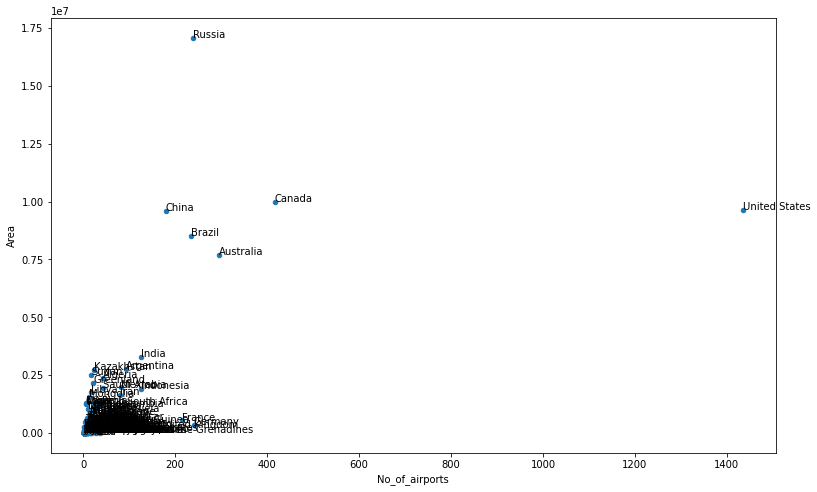

In [253]:
merged_pd = merged.toPandas().set_index('Country')

fig = merged_pd.plot.scatter(x='No_of_airports', y='Area', figsize=(13, 8))
for i, txt in enumerate(merged_pd.index):
  fig.annotate(txt, (merged_pd['No_of_airports'][i], merged_pd['Area'][i]))


Zad 5

In [254]:
merged_pd['Region'].unique()

array(['WESTERN EUROPE                     ',
       'ASIA (EX. NEAR EAST)         ', 'LATIN AMER. & CARIB    ',
       'SUB-SAHARAN AFRICA                 ',
       'NORTHERN AMERICA                   ',
       'EASTERN EUROPE                     ',
       'NEAR EAST                          ',
       'NORTHERN AFRICA                    ',
       'OCEANIA                            ', 'C.W. OF IND. STATES ',
       'BALTICS                            '], dtype=object)

In [291]:
def RegionToContinent(region):

  region = str(region)
  if region.startswith('ASIA'):
    return 'Asia'
  elif region.startswith('EASTERN EUROPE'):
    return 'Europe'
  elif region.startswith('NORTHERN AFRICA'):
    return 'Africa'
  elif region.startswith('WESTERN EUROPE'):
    return 'Europe'
  elif region.startswith('SUB-SAHARAN AFRICA'):
    return 'Africa'
  elif region.startswith('LATIN AMER.'):
    return 'South America'
  elif region.startswith('C.W. OF IND.'):
    return 'Asia'
  elif region.startswith('NEAR EAST'):
    return 'Asia'
  elif region.startswith('NORTHERN AMERICA'):
    return 'North America'
  elif region.startswith('BALTICS'):
    return 'Europe'
  elif region.startswith('OCEANIA'):
    return 'Australia'


Reg2Cont_udf = udf(RegionToContinent, StringType())

merged = merged.withColumn('Continent', Reg2Cont_udf('Region'))
merged.select("Country", "No_of_airports", "Continent").show()

+-------------+--------------+-------------+
|      Country|No_of_airports|    Continent|
+-------------+--------------+-------------+
|Faroe Islands|             5|       Europe|
|       Brunei|             2|         Asia|
|      Bolivia|            23|South America|
|       Zambia|            12|       Africa|
|       Canada|           417|North America|
|     Slovakia|             8|       Europe|
|      Romania|            19|       Europe|
|     Colombia|            74|South America|
|       Brazil|           234|South America|
|   Mauritania|            11|       Africa|
|    Hong Kong|             3|         Asia|
|    Greenland|            22|North America|
|         Oman|             6|         Asia|
| Saint Helena|             1|       Africa|
|    Mauritius|             2|       Africa|
|        Libya|            17|       Africa|
|       Cyprus|             4|         Asia|
|        Macau|             1|         Asia|
|         Iran|            81|         Asia|
|        A

In [292]:
merged_by_continent = merged \
              .groupby('Continent') \
              .sum('No_of_airports')

merged_by_continent = merged_by_continent.withColumnRenamed("sum(No_of_airports)", "No_of_airports")
merged_by_continent.show()

+-------------+--------------+
|    Continent|No_of_airports|
+-------------+--------------+
|       Europe|          1391|
|       Africa|           655|
|North America|          1875|
|South America|           921|
|         Asia|          1629|
|    Australia|           542|
+-------------+--------------+



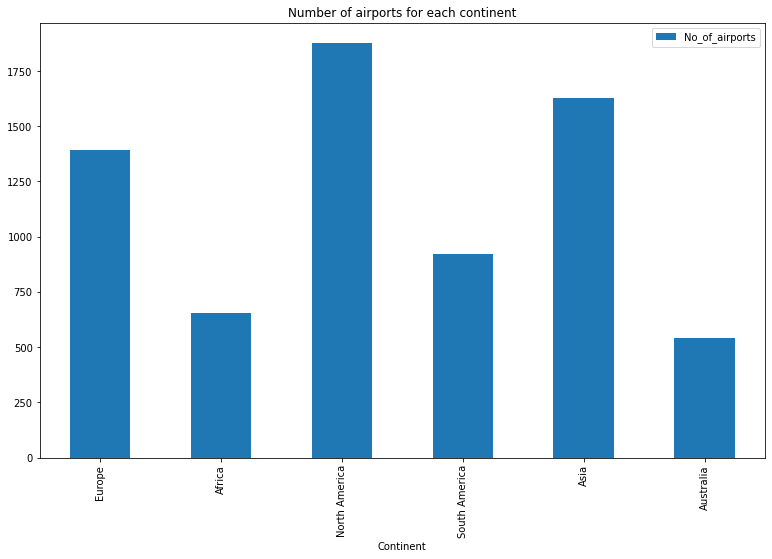

In [293]:

merged_by_continent_pd = merged_by_continent.toPandas()
fig = merged_by_continent_pd.plot.bar(x='Continent', y='No_of_airports', figsize=(13, 8), title="Number of airports for each continent")